## 《合成孔径雷达成像——算法与实现》中5.6 点目标示例  

### 零斜视角情况

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

In [2]:
from numpy import sinc,cos,arctan,angle,pi,abs,ceil,sqrt,exp
from numpy.fft import fft,fft2

## 参数设置
#  已知参数--》距离向参数
R_eta_c = 20e+3;                # 景中心斜距
Tr = 25e-6;                     # 发射脉冲时宽
Kr = 0.25e+12;                  # 距离向调频率
alpha_os_r = 1.2;               # 距离过采样率
Nrg = 256;                      # 距离线采样点数
#  计算参数--》距离向参数
Bw = abs(Kr)*Tr;                # 距离信号带宽
Fr = alpha_os_r*Bw;             # 距离向采样率
#  已知参数--》方位向参数
c = 3e+8;                       # 电磁传播速度
Vr = 150;                       # 等效雷达速度
Vs = Vr;                        # 卫星平台速度
Vg = Vr;                        # 波束扫描速度
f0 = 5.3e+9;                    # 雷达工作频率
Delta_f_dop = 80;               # 多普勒带宽
alpha_os_a = 1.3;               # 方位过采样率
Naz = 256;                      # 距离线数
theta_r_c = np.array([0,+22.8]);          # 波束斜视角
t_eta_c = np.array([0,-51.7]);            # 波束中心穿越时刻
f_eta_c = np.array([0,+2055]);            # 多普勒中心频率
#  计算参数--》方位向参数
lambda0 = c/f0;                  # 雷达工作波长
Fa = alpha_os_a*Delta_f_dop;    # 方位向采样率
#  参数计算
R0 = R_eta_c*cos(theta_r_c[0]);                         # 最短斜距
La = 0.886*2*Vs*cos(theta_r_c[0])/Delta_f_dop;          # 实际天线长度
theta_bw = 0.886*lambda0/La;                             # 方位向3dB波束宽度
Trr = Nrg/Fr;                   # 发射脉冲时宽
Taa = Naz/Fa;                   # 目标照射时间
Ka = 2*Vr**2/lambda0/R0;          # 方位向调频率
d_t_tau = 1/Fr;                 # 距离采样时间间隔
d_t_eta = 1/Fa;                 # 方位采样时间间隔
d_f_tau = Fa/Nrg;               # 距离采样频率间隔    
d_f_eta = Fa/Naz;               # 方位采样频率间隔
## 变量设置
#  时间变量                                                    
t_tau = np.arange(-Trr/2,Trr/2,d_t_tau) + 2*R_eta_c/c;   # 距离时间变量
t_eta = np.arange(-Taa/2,Taa/2,d_t_eta) + t_eta_c[0];    # 方位时间变量
#  坐标设置                                                                                                             
t_tauX,t_eta_Y= np.meshgrid(t_tau,t_eta);               # 设置二维网络坐标
## 信号设置
R_eta = R0 + Vr**2*t_eta_Y**2/(2*R0);                    # 瞬时斜率
A0 = 1;                                                 # 后向散射系数幅度
wr = np.where(abs(t_tauX-2*R_eta/c) <= Tr/2,1,0);                   # 距离向包络
wa = sinc(0.886*arctan(Vg*(t_eta_Y-t_eta_c[0])/R0)/theta_bw)**2;      # 方位向包络

#  接收信号
srt   = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);                                                        
srt_z = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);# 正扫频
srt_f = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(-1j*pi*Kr*(t_tauX-2*R_eta/c)**2);# 负扫频


-0.0


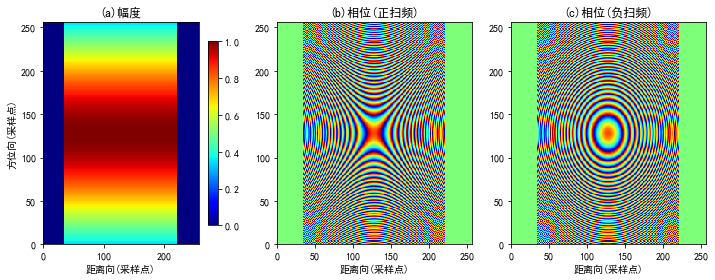

In [5]:
# 绘图
from matplotlib.pyplot import figure,subplot,plot,axis,title,xlabel,ylabel,text,arrow
eps = np.finfo(np.float64).eps
# 绘图      
figure(figsize=(10,4));
subplot(131)
c = plt.pcolor(abs(srt_z),cmap='jet')
plt.colorbar(shrink = .83)
xlabel('距离向(采样点)');ylabel('方位向(采样点)');title('(a)幅度');
subplot(132)
plt.pcolor(angle(srt_z+eps),cmap='jet')
xlabel('距离向(采样点)');title('(b)相位(正扫频)');
subplot(133)
# plt.pcolor(angle(srt_f))
plt.pcolor(angle(srt_f+eps),cmap='jet')
xlabel('距离向(采样点)');title('(c)相位(负扫频)');

plt.tight_layout()


#### 注：本例在实现过程中，遇到了负零的问题。对于一个实部是负零虚部是正零的复数，在计算其angle时，值变为$\pi$。见下例

In [31]:
a = srt[0][0]
print( repr(a))
print( "{0.real:.24f},{0.imag:.24f}j".format(a) )
print(angle(a))

(-0+0j)
-0.000000000000000000000000,0.000000000000000000000000j
3.141592653589793


#### 为了使其不要从零变为$\pi$,在计算angle之前，用最小的正浮点数加到该数上。是否有更好的方案，需进一步的探索。

下面是未加小数之前的效果，相位图的两边有斑纹。

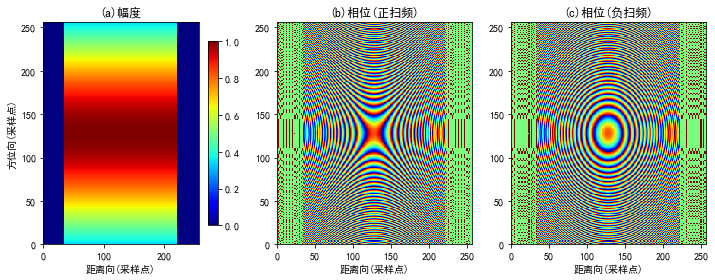

In [32]:
figure(figsize=(10,4));
subplot(131)
c = plt.pcolor(abs(srt_z),cmap='jet')
plt.colorbar(shrink = .83)
xlabel('距离向(采样点)');ylabel('方位向(采样点)');title('(a)幅度');
subplot(132)
plt.pcolor(angle(srt_z),cmap='jet')
xlabel('距离向(采样点)');title('(b)相位(正扫频)');
subplot(133)
# plt.pcolor(angle(srt_f))
plt.pcolor(angle(srt_f),cmap='jet')
xlabel('距离向(采样点)');title('(c)相位(负扫频)');

plt.tight_layout()

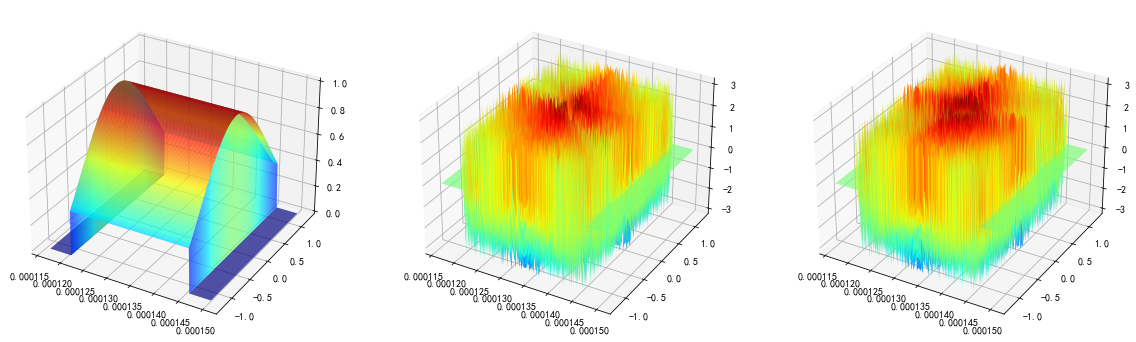

In [56]:
figure(figsize=(20,10));
ax1 = subplot(131,projection='3d')
ax1.plot_surface(t_tauX,t_eta_Y, abs(srt_z), rstride=1, cstride=1, cmap='jet', edgecolor='none')
# z1_plot = ax1.scatter(t_tauX,t_eta_Y,c = abs(srt_z),vmin=0.0,vmax=0.4)
# plt.colorbar(z1_plot,cax=ax1)
ax2 = subplot(132,projection='3d')
ax2.plot_surface(t_tauX,t_eta_Y, angle(srt_z+eps), rstride=1, cstride=1, cmap='jet', edgecolor='none')
ax3 = subplot(133,projection='3d')
ax3.plot_surface(t_tauX,t_eta_Y, angle(srt_f+eps), rstride=1, cstride=1, cmap='jet', edgecolor='none')
# ax.view_init(60, 35)
# plt.show()

本文Python代码参照Matlab代码自：https://github.com/wanghs008/SAR-SignalProcessing